## ML Pipeline Preparation

This notebook contains notes on how we should set up the ML pipeline for this project. It should perform the following steps:

- [Load the data](#Load-the-model)
- [Tokenize text data](#Tokenize-text-data)
- [Build ML pipeline](#Build-ML-pipeline)
- [Train ML pipeline](#Train-ML-pipeline)
- [Test ML model](#Test-ML-model)
- [Perform grid search](#Perform-grid-search)
- [Test tuned ML model](#Test-tuned-ML-model)
- [Further improvements](#Further-improvements)
- [Export model](#Export-model)

Note: This notebook must be run with python3 kernel since nltk is only compatible with Python3.

##  Load the model

We start by loading the model from the sqlite database we created in the etl pipeline.

In [1]:
from sqlalchemy import create_engine
import pandas as pd

In [2]:
engine = create_engine('sqlite:///DisasterResponse.db')
df = pd.read_sql('SELECT * FROM DisasterResponse', engine)
X = df.iloc[:, 0:4]
Y = df.iloc[:, 4:]

## Tokenize text data

For each message we perform the following:
- Divide (tokenize) the text into individual words
- Lemmatize each word back to its lemma (root)
- Set each word to lowercase

In [3]:
# Need to setup SSL to download ntlk packages
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Download nltk packages
import nltk
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger'])
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


def tokenize(text):
    """
    Tokenizes, lemmatizes and sets all characters to lowercase
    for the input text.
    
    Input:
    - text = string
    
    Output:
    - clean_tokens = list of words that have been lemmatized and lowercase
    """
    
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    clean_tokens = []
    for token in tokens:
        clean_token = lemmatizer.lemmatize(token).lower().strip()
        clean_tokens.append(clean_token)
    return clean_tokens

[nltk_data] Downloading package punkt to /Users/cheuklau/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/cheuklau/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/cheuklau/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


## Build ML pipeline

In this section we define the ML pipeline which should take in the message column and output classification results on the (36) categories column. The ML pipeline will perform the following:

1. Tokenize each message based on the tokenize function we defined in the previous section, and use CountVectorizer to get the count of each word.
2. Use TdidfTransfomer to compute tf-idf values based on the CountVectorizer results. 
3. Use MultiOutputClassifier with RandomForestClassifer to fit our model over multiple target variables (36 categories).

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier()))
])

## Train ML pipeline

In this step we split the dataset into training and testing data then fit the pipeline to the training data.

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y)
pipeline.fit(X_train['message'], y_train);

## Test ML model

In this step we run the model on our test data then for each category, we calculate the following:
- Recall = TP / (TP + FN) = out of all actual positive classes, how many did we predict correctly
- Precision = TP / (TP + FP) = out of all positive classes we predicted, how many are actually positive
- Accuracy = (TP + TN) / Total = out of all cases how many did we predict correctly
- F1 score  = 2 * Recall * Precision / (Recall + Precision) = measures recall and precision at the same time by using their harmonic mean

Note that we use the weighted average of the two classes (0s or 1s) within each category. This accounts for the fact that one class may be dominant over another within a given category.

In [6]:
# Generate the predictions
y_pred = pipeline.predict(X_test['message'])

In [7]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline

def display_results(y_test, y_pred):
    """
    Calculate and plot recall, precision, f1-score and accuracy
    
    Input:
    - y_test = test response vector
    - y_pred = predicted response vector
    
    Output:
    - None
    """
    
    # Go through each category, calculate and store the QOIs
    recall    = []
    precision = []
    f1_score  = []
    accuracy  = []
    for i in range(0, 36):
        result = classification_report(y_test.iloc[:, i], [x[i] for x in y_pred], output_dict=True)
        recall.append(result['weighted avg']['recall'])
        precision.append(result['weighted avg']['precision'])
        f1_score.append(result['weighted avg']['f1-score'])
        accuracy.append(result['accuracy'])
    
    # Sort QOIs for plotting
    recall.sort()
    precision.sort()
    f1_score.sort()
    accuracy.sort()
    plt.plot(recall, label='recall')
    plt.plot(precision, label='precision')
    plt.plot(f1_score, label='f1-score')
    plt.plot(accuracy, label='accuracy')
    plt.legend()
    
    print('Min recall: {}, Max recall: {}'.format(recall[0], recall[-1]))
    print('Min precision: {}, Max precision: {}'.format(precision[0], precision[-1]))
    print('Min f1_score: {}, Max f1_score: {}'.format(f1_score[0], f1_score[-1]))
    print('Min accuracy: {}, Max accuracy: {}'.format(accuracy[0], accuracy[-1]))

Let's plot and display the min and max of each QOI.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Min recall: 0.7677754043332317, Max recall: 1.0
Min precision: 0.7681807583848445, Max precision: 1.0
Min f1_score: 0.7622773235640554, Max f1_score: 1.0
Min accuracy: 0.7677754043332317, Max accuracy: 1.0


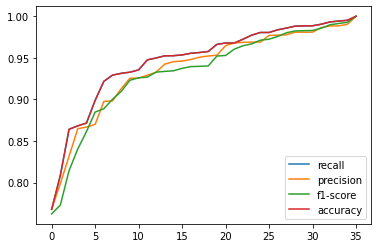

In [8]:
display_results(y_test, y_pred)

## Perform grid search

Use grid search to tune the hyperparameters in the previous pipeline.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define list of parameters and values to test in grid search
# parameters = {
#     'vect__ngram_range': ((1, 1), (1, 2)),
#     'vect__max_df': (0.5, 0.75, 1.0),
#     'vect__max_features': (None, 5000, 10000),
#     'tfidf__use_idf': (True, False),
#     'clf__estimator__n_estimators': [50, 100, 200],
#     'clf__estimator__min_samples_split': [2, 3, 4]
# }

# Reduce parameter tuning to save time
parameters = {
    'vect__max_features': (5000, 10000),
    'tfidf__use_idf': (True, False),
    'clf__estimator__n_estimators': [100, 200],
}

cv = GridSearchCV(pipeline, param_grid=parameters)
cv.fit(X_train['message'], y_train)

## Test tuned ML model

Calculate the same QOI as before but for the tuned ML model.

In [ ]:
# Generate predictions using the tuned model
y_pred_cv = cv.predict(X_test['message'])

display_results(y_test, y_pred_cv)

## Further improvements

In this section we try to further improve the model using an alternative classifier algorithm known as XGBoost. Future work should perform hyperparameter tuning for XGBoost as well.

In [ ]:
from xgboost import XGBClassifier

pipeline_xgb = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(XGBClassifier()))
])

## Export model

In this section, we export our best-performing model as a pickle file.

In [ ]:
import pickle

pickle.dump(cv, open('classifier.pkl', 'wb'))